# Calculating tide statistics and satellite biases

**This guide demonstrates how to use the [`tide_stats`](../../api/#eo_tides.stats.tide_stats) and  [`pixel_stats`](../../api/#eo_tides.stats.pixel_stats) functions from [`eo_tides.stats`](../../api/#eo_tides.stats) to calculate local tide statistics and identify biases caused by interactions between tidal processes and satellite orbits.**

Complex interactions between temporal tide dynamics and the regular mid-morning overpass timing of sun-synchronous sensors like Landsat or Sentinel-2 mean that satellites often do not observe the entire tidal cycle. 
Biases in satellite coverage of the tidal cycle can mean that tidal extremes (e.g. the lowest or highest tides at a location) may either never be captured by satellites, or be over-represented in the satellite EO record. 
Local tide dynamics can cause these biases to vary greatly both through time and spatially (Figure 1), making it challenging to consistently analyse and compare coastal processes consistently - particularly for large-scale (e.g. regional or global) analyses.

To ensure that coastal EO analyses are not inadvertently affected by tide biases, it is important to compare how well the tides observed by satellites match the full range of tides at a location.
The `tidal_stats` and `pixel_stats` functions compares the subset of tides observed by satellite data against the full range of tides modelled at a regular interval through time (every two hours by default) across the entire time period covered by the satellite dataset.
This comparison is used to calculate several useful statistics and plots that summarise how well your satellite data capture real-world tidal conditions.

> **Figure 1:** Example of tide biases in Landsat satellite data across coastal Australia ([Bishop-Taylor et al. 2018](https://www.sciencedirect.com/science/article/pii/S0272771418308783#sec3)). "Spread" represents the proportion of the astronomical tide range observed by satellites; low and high tide "offsets" represent the proportion of highest and lowest tides never observed.

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S0272771418308783-gr8_lrg.jpg" alt="Tide bias figure">

<div class="admonition tip">
    <p class="admonition-title">Tip</p>
    <p>
        For a more detailed discussion of the issue of tidal bias in sun-synchronous satellite observations of the coastline, refer to the 'Limitations and future work' section in <a href="https://www.sciencedirect.com/science/article/pii/S0272771418308783#sec3">Bishop-Taylor et al. 2018.</a>
    </p>
</div>

## Getting started
As in the previous examples, our first step is to tell `eo-tides` the location of our tide model or clipped tide model directory (if you haven't set this up, [refer to the setup instructions here](../../setup)):

In [1]:
directory = "../../tests/data/tide_models/"

## Load Sentinel-2 satellite data using odc-stac

We can now load a time-series of satellite data over our area of interest using the Open Data Cube's `odc-stac` package. 
In this example, we will load **Sentinel-2** satellite data from **2021-2023** over the city of **Broome, Western Australia**.
We will load this data from the [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) STAC catalogue.

<div class="admonition tip">
    <p class="admonition-title">Tip</p>
    <p>
        For a more detailed guide to using STAC metadata and <code>odc-stac</code> to find and load satellite data, refer to the <a href="https://knowledge.dea.ga.gov.au/guides/setup/gis/stac/">STAC user guide</a> here.
    </p>
</div>

In [2]:
import odc.stac
import pystac_client
import planetary_computer

# Connect to STAC catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Set cloud access defaults
odc.stac.configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
)

# Build a query and search the STAC catalog for all matching items
bbox = [122.160, -18.05, 122.260, -17.95]
query = catalog.search(
    bbox=bbox,
    collections=["sentinel-2-l2a"],
    datetime="2021/2023",
)

# Load data into xarray format
ds_s2 = odc.stac.load(
    items=list(query.items()),
    bands=["red"],
    crs="utm",
    resolution=30,
    groupby="solar_day",
    bbox=bbox,
    fail_on_error=False,
    chunks={},
)

print(ds_s2)

<xarray.Dataset> Size: 111MB
Dimensions:      (y: 371, x: 356, time: 211)
Coordinates:
  * y            (y) float64 3kB 8.015e+06 8.015e+06 ... 8.004e+06 8.004e+06
  * x            (x) float64 3kB 4.11e+05 4.111e+05 ... 4.217e+05 4.217e+05
    spatial_ref  int32 4B 32751
  * time         (time) datetime64[ns] 2kB 2021-01-03T02:04:51.024000 ... 202...
Data variables:
    red          (time, y, x) float32 111MB dask.array<chunksize=(1, 371, 356), meta=np.ndarray>


## Using tide_stats

Once we have loaded some satellite data, we can pass this to the `tide_stats` function to calculate local tide statistics and reveal any potential tidal biases.
The `tide_stats` function will return a plain-text summary below, as well as a visual plot that compares the distribution of satellite-observed tides (black dots) against the full range of modelled astronomical tide conditions (blue) using three useful metrics:

1. **Spread:** The proportion of the full modelled astronomical tidal range that was observed by satellites. A high value indicating good coverage of the tide range.
2. **Offset high:** The proportion of the highest tides not observed by satellites at any time, as a proportion of the full modelled astronomical tidal range. A high value indicates that the satellite data is biased towards never capturing high tides.
3. **Offset low:** The proportion of the lowest tides not observed by satellites at any time, as a proportion of the full modelled astronomical tidal range. A high value indicates that the satellite data is biased towards never capturing low tides.

<div class="admonition tip">
    <p class="admonition-title">Tip</p>
    <p>
        For a more detailed description of these biases, see <a href="https://www.sciencedirect.com/science/article/pii/S0272771418308783#sec3">Bishop-Taylor et al. 2018.</a>
    </p>
</div>

Using tide modelling location: 122.21, -18.00
Modelling tides with EOT20
Modelling tides with EOT20


🌊 Modelled astronomical tide range: 9.30 metres.
🛰️ Observed tide range: 6.29 metres.

🔴 68% of the modelled astronomical tide range was observed at this location.
🟢 The highest 8% (0.77 metres) of the tide range was never observed.
🔴 The lowest 24% (2.25 metres) of the tide range was never observed.

🌊 Mean modelled astronomical tide height: -0.00 metres.
🛰️ Mean observed tide height: 0.69 metres.

⬆️ The mean observed tide height was 0.69 metres higher than the mean modelled astronomical tide height.


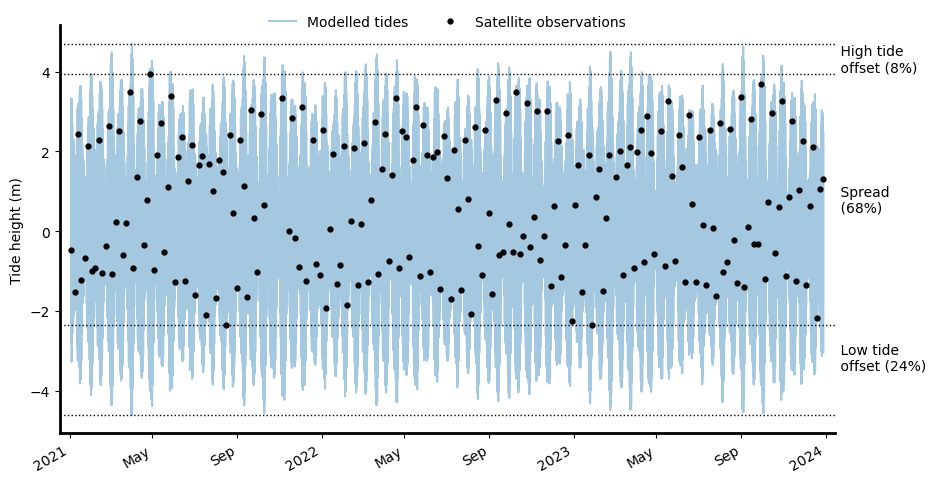

In [3]:
from eo_tides.stats import tide_stats

statistics_df = tide_stats(
    data=ds_s2,
    directory=directory,
)


As we can see in the graph, Sentinel-2 captured a biased proportion of the tide range at this location: only observing ~64% of the tide range, and never observing the lowest 26% of tides.

The `tide_stats` function also outputs a `pandas.Series` object containing statistics for the results above, including:

* `y`: latitude used for modelling tide heights
* `x`: longitude used for modelling tide heights
* `mot`: mean tide height observed by the satellite (metres)
* `mat`: mean modelled astronomical tide height (metres)
* `lot`: minimum tide height observed by the satellite (metres)
* `lat`: minimum tide height from modelled astronomical tidal range (metres)
* `hot`: maximum tide height observed by the satellite (metres)
* `hat`: maximum tide height from modelled astronomical tidal range (metres)
* `otr`: tidal range observed by the satellite (metres)
* `tr`: modelled astronomical tide range (metres)
* `spread`: proportion of the full modelled tidal range observed by the satellite
* `offset_low`: proportion of the lowest tides never observed by the satellite
* `offset_high`: proportion of the highest tides never observed by the satellite

In [4]:
statistics_df

y              -18.000
x              122.210
mot              0.691
mat             -0.000
lot             -2.355
lat             -4.604
hot              3.930
hat              4.696
otr              6.285
tr               9.300
spread           0.676
offset_low       0.242
offset_high      0.082
dtype: float64

### Compare against Sentinel-1 tide biases

In the previous example, we saw that Sentinel-2 data was biased towards never capturing low tide at our location.
These biases are caused by the consistent 10:30 am local overpass time of the Sentinel-2 satellites, which due to a phenomenon called "tide-aliasing" means that certain tides never occur when the satellite overpasses.

One possible way around these biases is to use different satellite data from satellites that overpass at different times.
For example, Sentinel-1 radar satellites follow a different orbit to Sentinel-2, overpassing at a local time of 6:00 pm instead of 10:30 am. 
This diference in overpass time potentially means that Sentinel-1 satellite data may capture different tides to Sentinel-2.

In the next example, we run the `tide_stats` function on data loaded from **Sentinel-1** for the same location and time period to see if this data is affected by the same tide biases.

In [5]:
# Build a query and search the STAC catalog for all matching items
bbox = [122.160, -18.05, 122.260, -17.95]
query = catalog.search(
    bbox=bbox,
    collections=["sentinel-1-rtc"],
    datetime="2021/2023",
)

# Load data into xarray format
ds_s1 = odc.stac.load(
    items=list(query.items()),
    bands=["vv"],
    crs="utm",
    resolution=30,
    groupby="solar_day",
    bbox=bbox,
    fail_on_error=False,
    chunks={},
)

print(ds_s1)

<xarray.Dataset> Size: 47MB
Dimensions:      (y: 371, x: 356, time: 89)
Coordinates:
  * y            (y) float64 3kB 8.015e+06 8.015e+06 ... 8.004e+06 8.004e+06
  * x            (x) float64 3kB 4.11e+05 4.111e+05 ... 4.217e+05 4.217e+05
    spatial_ref  int32 4B 32751
  * time         (time) datetime64[ns] 712B 2021-01-07T21:23:20.996123 ... 20...
Data variables:
    vv           (time, y, x) float32 47MB dask.array<chunksize=(1, 371, 356), meta=np.ndarray>


When we run `tide_stats`, we can see a very different pattern: Sentinel-1 data is biased towards *low tide* observations, and never observes high tide at our location!

Using tide modelling location: 122.21, -18.00
Modelling tides with EOT20
Modelling tides with EOT20


🌊 Modelled astronomical tide range: 9.55 metres.
🛰️ Observed tide range: 6.40 metres.

🔴 67% of the modelled astronomical tide range was observed at this location.
🔴 The highest 28% (2.72 metres) of the tide range was never observed.
🟢 The lowest 4% (0.43 metres) of the tide range was never observed.

🌊 Mean modelled astronomical tide height: -0.00 metres.
🛰️ Mean observed tide height: -1.31 metres.

⬇️ The mean observed tide height was -1.31 metres lower than the mean modelled astronomical tide height.


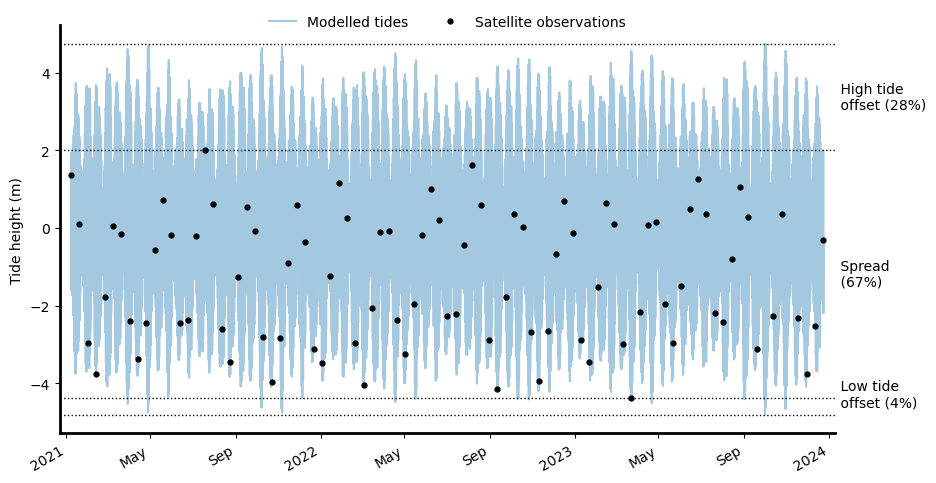

In [6]:
statistics_df = tide_stats(
    data=ds_s1,
    directory=directory,
)


### Calculate biases for multiple satellite sensors
At our location, Sentinel-2 optical satellites are biased towards high tide observations, while Sentinel-1 radar satellites are biased towards low tide observations. 
Could combining data from multiple EO sensors help us capture a more complete view of tides at this location?

To test this theory, we can combine Sentinel-2 and Sentinel-1 data into a single `xarray.Dataset`, recording the name of each sensor using a new `satellite_name` coordinate in our data:

In [7]:
import xarray as xr

# Give each observation a "satellite_name" based on its satellite
ds_s1 = ds_s1.assign_coords(satellite_name=("time", ["Sentinel-1"] * ds_s1.sizes["time"]))
ds_s2 = ds_s2.assign_coords(satellite_name=("time", ["Sentinel-2"] * ds_s2.sizes["time"]))

# Combine both Sentinel-1 and Sentinel-2 data into a single dataset
ds_all = xr.concat([ds_s1, ds_s2], dim="time")
print(ds_all)

<xarray.Dataset> Size: 317MB
Dimensions:         (time: 300, y: 371, x: 356)
Coordinates:
  * y               (y) float64 3kB 8.015e+06 8.015e+06 ... 8.004e+06 8.004e+06
  * x               (x) float64 3kB 4.11e+05 4.111e+05 ... 4.217e+05 4.217e+05
    spatial_ref     int32 4B 32751
  * time            (time) datetime64[ns] 2kB 2021-01-07T21:23:20.996123 ... ...
    satellite_name  (time) <U10 12kB 'Sentinel-1' 'Sentinel-1' ... 'Sentinel-2'
Data variables:
    vv              (time, y, x) float32 158MB dask.array<chunksize=(1, 371, 356), meta=np.ndarray>
    red             (time, y, x) float32 158MB dask.array<chunksize=(1, 371, 356), meta=np.ndarray>


We can now run `tide_stats` again.
This time, we pass our satellite name coordinate to the function using the `plot_col="satellite_name"` parameter.
This will plot data from each of our satellites using a different symbol.

Using tide modelling location: 122.21, -18.00
Modelling tides with EOT20
Modelling tides with EOT20


🌊 Modelled astronomical tide range: 9.30 metres.
🛰️ Observed tide range: 8.32 metres.

🟡 89% of the modelled astronomical tide range was observed at this location.
🟢 The highest 8% (0.77 metres) of the tide range was never observed.
🟢 The lowest 2% (0.22 metres) of the tide range was never observed.

🌊 Mean modelled astronomical tide height: -0.00 metres.
🛰️ Mean observed tide height: 0.10 metres.

⬆️ The mean observed tide height was 0.10 metres higher than the mean modelled astronomical tide height.


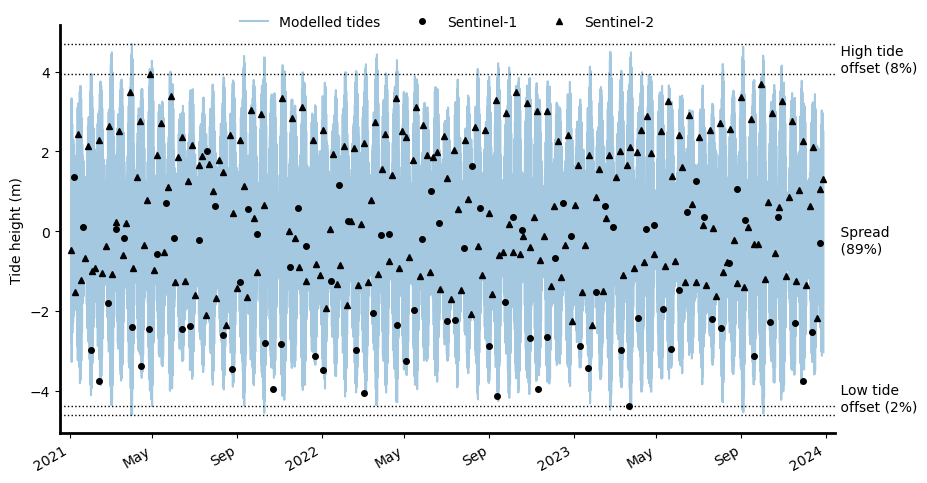

In [8]:
statistics_df = tide_stats(
    data=ds_all,
    plot_col="satellite_name",
    directory=directory,
)


We can see that at this location, combining Sentinel-2 and Sentinel-1 data greatly improves our biases: our satellite data now covers ~85% of the modelled astronomical tide range, and only fails to observe 10% of the highest tides and 6% of the lowest tides!

## Using pixel_stats

### Modelling tide statistics and biases spatially

Because tide regimes and satellite biases can vary greatly along the coast, it can be useful to plot these biases spatially.
To do this, we can use the `pixel_stats` function. 

`pixel_stats` works similarly to `tide_stats`, except statistics are calculated across the entire extent of your satellite dataset. 
The function will generate an `xarray.Dataset` output containing the statistics discussed above as two-dimensional arrays.

<div class="admonition tip">
    <p class="admonition-title">Tip</p>
    <p>
        The <code>pixel_stats</code> function uses <a href="../../api/#eo_tides.eo.pixel_tides"><code>eo_tides.eo.pixel_tides</code></a> to model tides spatially. You can experiment passing in parameters like <code>resolution</code> and <code>buffer</code> to customise the modelling grid used for calculating tide biases. Be warned however that you can quickly run out of memory with large analyses, given the number of timesteps required to model astronomical low and high tide.
    </p>
</div>

In [9]:
from eo_tides.stats import pixel_stats

stats_ds = pixel_stats(
    data=ds_s2,
    directory=directory,
)
print(stats_ds)

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides with EOT20
Computing tide quantiles
Returning low resolution tide array
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides with EOT20
Computing tide quantiles
Returning low resolution tide array
<xarray.Dataset> Size: 2kB
Dimensions:      (x: 8, y: 8)
Coordinates:
  * x            (x) float64 64B 3.975e+05 4.025e+05 ... 4.275e+05 4.325e+05
  * y            (y) float64 64B 8.028e+06 8.022e+06 ... 7.998e+06 7.992e+06
    tide_model   <U5 20B 'EOT20'
    spatial_ref  int32 4B 32751
Data variables:
    hot          (y, x) float32 256B 3.773 3.794 3.844 3.844 ... 3.953 3.953 nan
    hat          (y, x) float32 256B 4.282 4.318 4.408 4.408 ... 4.797 4.797 nan
    lot          (y, x) float32 256B -2.109 -2.128 -2.18 ... -2.418 -2.418 nan
    lat          (y, x) float32 256B -4.222 -4.264 -4.353 ... -4.692 -4.692 nan
    otr          (y, x) float32 256B 5.882 5.922 6.023 6.023 ...

We can explore these statistics on a map:

In [10]:
stats_ds.spread.odc.explore()

Or plot them directly:

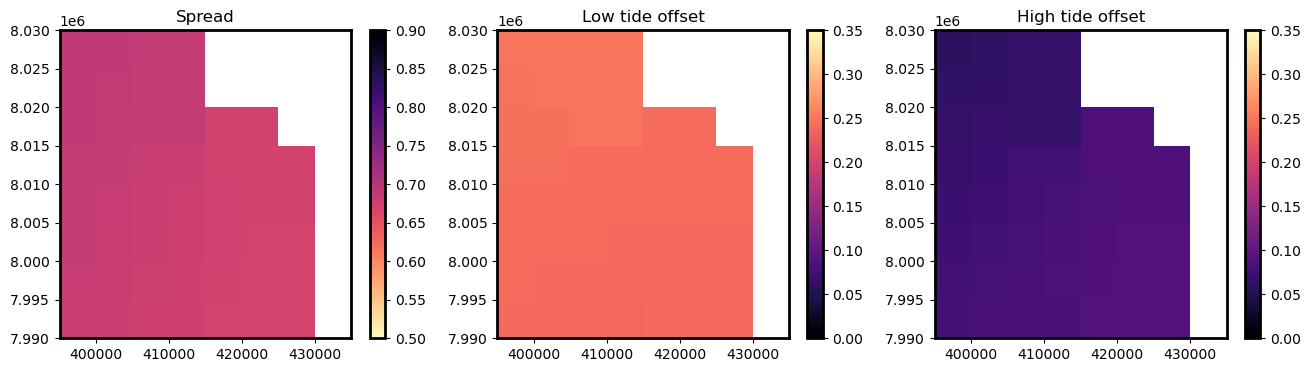

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
stats_ds.spread.plot(ax=axes[0], vmin=0.5, vmax=0.9, cmap="magma_r", add_labels=False)
stats_ds.offset_low.plot(ax=axes[1], vmin=0, vmax=0.35, cmap="magma", add_labels=False)
stats_ds.offset_high.plot(ax=axes[2], vmin=0, vmax=0.35, cmap="magma", add_labels=False)
axes[0].set_title("Spread")
axes[1].set_title("Low tide offset")
axes[2].set_title("High tide offset");

## Next steps

We have explored calculating tide statistics and biases in EO data. Now we can learn how to validate modelled tides against [measured tide gauge data](../Validating_tides) to ensure the tides we are modelling are accurate.